This colab was developed by Arnold Charry Armero.

# S&OP Aggregate Planning

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 37.6 MB/s eta 0:00:00


In [ ]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#We make sure we can see all the content
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
#Sets - t (TimePeriods)
t = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
PERIODSt = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

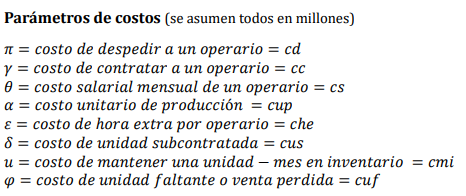

In [ ]:
#Cost Parameters
pi = 1.10
gamma = 1.30
theta = 2.68
alpha = 0.006975
epsilon = 0.018950
delta = 0.010320
u = 0.0005197
phi = 0.011271

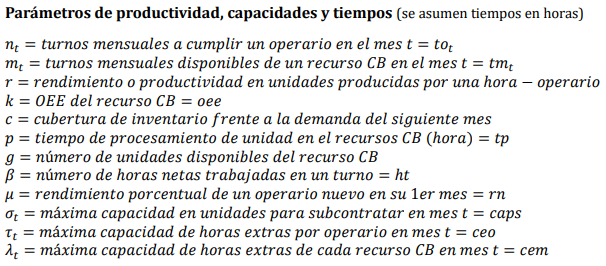

In [ ]:
#Productivity Parameters, Capacities and Times
Nt = {1:23, 2:20, 3:23, 4:23, 5:23, 6:23, 7:10, 8:16, 9:21, 10:23, 11:20, 12:23}
Mt = {1:42, 2:43, 3:45, 4:44, 5:48, 6:42, 7:22, 8:30, 9:40, 10:44, 11:38, 12:47}
r = 8.73
k = 0.81
c = 0.75
p = 0.009
g = 3
betha = 8
miu = 0.6
SIGMAt = {1:4200, 2:4200, 3:4200, 4:4200, 5:4200, 6:4200, 7:3000, 8:3000, 9:3000, 10:4200, 11:4200, 12:4200}
TAOt = {1:16, 2:0, 3:16, 4:16, 5:16, 6:16, 7:0, 8:0, 9:16, 10:16, 11:0, 12:16}
LAMBDAt = {1:46, 2:48, 3:48, 4:44, 5:48, 6:44, 7:28, 8:36, 9:42, 10:46, 11:40, 12:48}

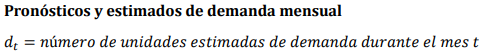

In [ ]:
Dt = {1:28430, 2:31410, 3:30400, 4:32570, 5:34520, 6:32660, 7:40800, 8:33450, 9:27980, 10:29550, 11:32740, 12:36420, 13: 31273}
DEMANDt = [28430, 31410, 30400, 32570, 34520, 32660, 40800, 33450, 27980, 29550, 32740, 36420]

In [ ]:
# Setting the problem
prob = LpProblem("Aggregate_Production_Planning", LpMinimize)

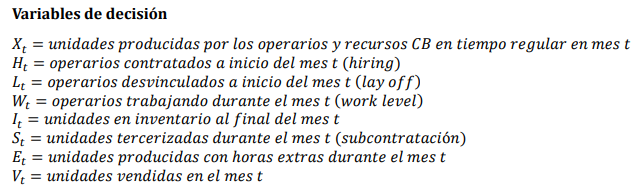

In [ ]:
#Decision Variables
Xt = LpVariable.dicts("Unidades producidas por los operarios y recursos CB en tiempo regular en mes t",t, lowBound = 0, cat = "Integer")
Ht = LpVariable.dicts("Operarios contratados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Lt = LpVariable.dicts("Operarios desvinculados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Wt = LpVariable.dicts("Operarios trabajando durante el mes t",t, lowBound = 0, cat = "Integer")
It = LpVariable.dicts("Unidades en inventario al final del mes t",t, lowBound = 0, cat = "Integer")
St = LpVariable.dicts("Unidades tercerizadas durante el mes t",t, lowBound = 0, cat = "Integer")
Et = LpVariable.dicts("Unidades producidas con horas extras durante el mes t",t, lowBound = 0, cat = "Integer")
Vt = LpVariable.dicts("Unidades vendidas durante el mes t",t, lowBound = 0, cat = "Integer")
Ft = LpVariable.dicts("Unidades faltantes del mes t", t, lowBound = 0, cat = "Integer")

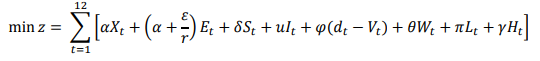

In [ ]:
#Objective Function
prob += lpSum(alpha*Xt[i] for i in t[1:13]) + lpSum((alpha+(epsilon / r))*Et[i] for i in t[1:13]) + lpSum(delta * St[i] for i in t[1:13]) + lpSum(u * It[i] for i in t[1:13]) + lpSum(phi * (Dt[i]-Vt[i]) for i in t[1:13]) + lpSum(theta * Wt[i] for i in t[1:13]) + lpSum(pi * Lt[i] for i in t[1:13]) + lpSum(gamma * Ht[i] for i in t[1:13])

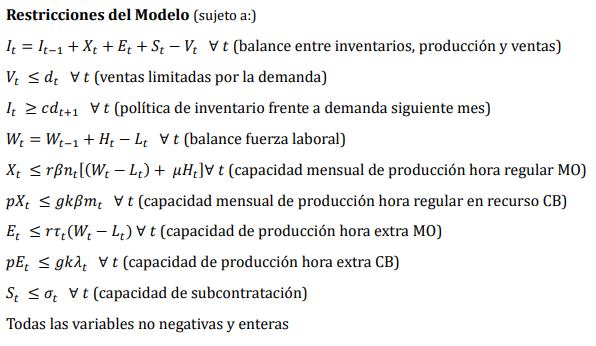

In [ ]:
#Contraints
prob += It[0] == 24152
prob += Wt[0] == 21

for i in t[1:13]:
  prob += (It[i-1] + Xt[i] + Et[i] + St[i] - Vt[i]) == It[i] # Inventory Balance Equation
for i in t[1:13]:
  prob += c*Dt[i+1] <= It[i] #Policy Constraint
for i in t[1:13]:
  prob += (Wt[i-1] + Ht[i] - Lt[i]) == Wt[i] #Work Balance Equation
for i in t[1:13]:
  prob += Xt[i] <= (r * betha * Nt[i] * ((Wt[i-1] - Lt[i]) + miu * Ht[i]))  #Monthly Production Capacity regular hour MO
for i in t[1:13]:
  prob += p * Xt[i] <= g * k * betha * Mt[i] #Monthly production capacity regular hour MO in bottleneck resource
for i in t[1:13]:
  prob += Et[i] <= (r * TAOt[i] * (Wt[i-1] - Lt[i])) #Production capacity overtime MO
for i in t[1:13]:
  prob += p * Et[i] <= (g * k * LAMBDAt[i]) #Production Capacity Overtime Bottleneck
for i in t[1:13]:
  prob += St[i] <= SIGMAt[i] #Outsourcing capacity
for i in t[1:13]:
  prob += Vt[i] <= Dt[i]  # Sales Limited by Demand
for i in t[1:13]:
  prob += Dt[i] - Vt[i] == Ft[i] #Shortage Equation

In [ ]:
prob.solve()
print("Solution Status = ", LpStatus[prob.status])

Solution Status =  Optimal


In [ ]:
Name_Variables = []
Solution_Variables = []
for v in prob.variables():
  A = v.name
  B = v.varValue
  print(v.name, "=", v.varValue)
  Name_Variables.append(A)
  Solution_Variables.append(B)

Operarios_contratados_a_inicio_del_mes_t_1 = 0.0
Operarios_contratados_a_inicio_del_mes_t_10 = 0.0
Operarios_contratados_a_inicio_del_mes_t_11 = 0.0
Operarios_contratados_a_inicio_del_mes_t_12 = 0.0
Operarios_contratados_a_inicio_del_mes_t_2 = 0.0
Operarios_contratados_a_inicio_del_mes_t_3 = 0.0
Operarios_contratados_a_inicio_del_mes_t_4 = 5.0
Operarios_contratados_a_inicio_del_mes_t_5 = 0.0
Operarios_contratados_a_inicio_del_mes_t_6 = 0.0
Operarios_contratados_a_inicio_del_mes_t_7 = 0.0
Operarios_contratados_a_inicio_del_mes_t_8 = 0.0
Operarios_contratados_a_inicio_del_mes_t_9 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_1 = 1.0
Operarios_desvinculados_a_inicio_del_mes_t_10 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_11 = 1.0
Operarios_desvinculados_a_inicio_del_mes_t_12 = 1.0
Operarios_desvinculados_a_inicio_del_mes_t_2 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_3 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_4 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_5 = 0.

In [ ]:
# Goal Function
print("Cost Function is $", value(prob.objective))

Cost Function is $ 3654.907698830929


In [ ]:
list_of_tuples = list(zip(Name_Variables, Solution_Variables))
df = pd.DataFrame(list_of_tuples, columns = ['Name_Decision_Variable', 'Value_Decision_Variable'])
df['letter'] = df.Name_Decision_Variable.apply(lambda x: x[:-2])
df['number'] = df.Name_Decision_Variable.apply(lambda x: int(x[-1:]))
df = df.sort_values(by=['letter', 'number'])
df1 = df[['Name_Decision_Variable', 'Value_Decision_Variable']]
df1

,Name_Decision_Variable,Value_Decision_Variable
0,Operarios_contratados_a_inicio_del_mes_t_1,0.0
4,Operarios_contratados_a_inicio_del_mes_t_2,0.0
5,Operarios_contratados_a_inicio_del_mes_t_3,0.0
6,Operarios_contratados_a_inicio_del_mes_t_4,5.0
7,Operarios_contratados_a_inicio_del_mes_t_5,0.0
8,Operarios_contratados_a_inicio_del_mes_t_6,0.0
9,Operarios_contratados_a_inicio_del_mes_t_7,0.0
10,Operarios_contratados_a_inicio_del_mes_t_8,0.0
11,Operarios_contratados_a_inicio_del_mes_t_9,0.0
1,Operarios_contratados_a_inicio_del_mes_t_10,0.0


In [ ]:
# We are going to analize if we met the demand
Sales_model1 = df1[df1['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_vendidas_durante_el_mes_t' in Name_Decision_Variable)]
Sales_model1['Monthly_Demand'] = DEMANDt
Sales_per_month = list(Sales_model1['Value_Decision_Variable'])
Sales_model1

Work_Force1 = df1[df1['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Operarios_trabajando_durante_el_mes_t' in Name_Decision_Variable)]
# Extract the values from the 'Value_Decision_Variable' column
Work_Force_per_month = list(Work_Force1['Value_Decision_Variable'][1:13])

# Check the lengths of the arrays
print(len(PERIODSt), len(Work_Force_per_month))


12 12


<ipython-input-25-fa3ef1a30af3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_model1['Monthly_Demand'] = DEMANDt


<ipython-input-26-2a00f136fe6a>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
<ipython-input-26-2a00f136fe6a>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Sales_per_month, 'r.-', label = 'Ventas', c = 'green')


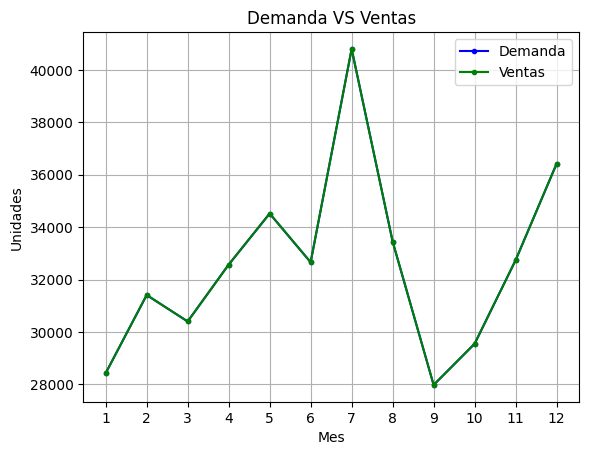

In [ ]:
plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
plt.plot(PERIODSt, Sales_per_month, 'r.-', label = 'Ventas', c = 'green')

plt.title('Demanda VS Ventas')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Work_Force1 = df1[df1['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Operarios_trabajando_durante_el_mes_t' in Name_Decision_Variable)]
Work_Force1

,Name_Decision_Variable,Value_Decision_Variable
24,Operarios_trabajando_durante_el_mes_t_0,21.0
25,Operarios_trabajando_durante_el_mes_t_1,20.0
29,Operarios_trabajando_durante_el_mes_t_2,20.0
30,Operarios_trabajando_durante_el_mes_t_3,20.0
31,Operarios_trabajando_durante_el_mes_t_4,25.0
32,Operarios_trabajando_durante_el_mes_t_5,25.0
33,Operarios_trabajando_durante_el_mes_t_6,25.0
34,Operarios_trabajando_durante_el_mes_t_7,25.0
35,Operarios_trabajando_durante_el_mes_t_8,25.0
36,Operarios_trabajando_durante_el_mes_t_9,22.0


12 12


<ipython-input-28-9dde03f14688>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Work_Force_per_month, 'r.-',label = 'Operarios', c = 'red')


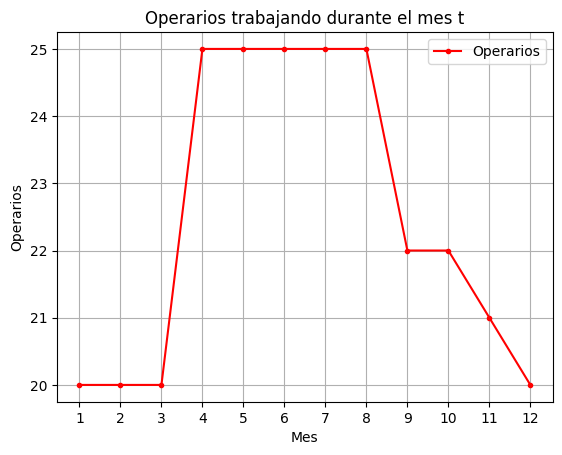

In [ ]:
# Check the lengths of the arrays
print(len(PERIODSt), len(Work_Force_per_month))

# Adjust the data or the plotting range accordingly.
# For example, if you are sure Work_Force_per_month should have 12 elements:
Work_Force_per_month = Work_Force_per_month[:12]  # Trim the list

# Now plot the data
plt.plot(PERIODSt, Work_Force_per_month, 'r.-',label = 'Operarios', c = 'red')

plt.title('Operarios trabajando durante el mes t')
plt.xlabel('Mes')
plt.ylabel('Operarios')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Inventory_Model1 = df1[df1['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_en_inventario_al_final_del_mes_t' in Name_Decision_Variable)]
Inventory_Model1

,Name_Decision_Variable,Value_Decision_Variable
37,Unidades_en_inventario_al_final_del_mes_t_0,24152.0
38,Unidades_en_inventario_al_final_del_mes_t_1,27848.0
42,Unidades_en_inventario_al_final_del_mes_t_2,24374.0
43,Unidades_en_inventario_al_final_del_mes_t_3,26100.0
44,Unidades_en_inventario_al_final_del_mes_t_4,30475.0
45,Unidades_en_inventario_al_final_del_mes_t_5,37438.0
46,Unidades_en_inventario_al_final_del_mes_t_6,48428.0
47,Unidades_en_inventario_al_final_del_mes_t_7,25088.0
48,Unidades_en_inventario_al_final_del_mes_t_8,20985.0
49,Unidades_en_inventario_al_final_del_mes_t_9,25271.0


In [ ]:
Inventory_per_month = list(Inventory_Model1['Value_Decision_Variable'])
Minimum_with_policy = []
for i in range(12):
  value_minimum = 0.75 * Dt[i+2]
  Minimum_with_policy.append(value_minimum)

Minimum_with_policy = list(Minimum_with_policy)

12 13


<ipython-input-31-e137984e75f9>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt[:12], Inventory_per_month, 'r.-',label = 'Inventario hasta final de mes', c = 'orange') # Also slice PERIODSt to 12 elements to match
<ipython-input-31-e137984e75f9>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt[:12], Minimum_with_policy, 'r.-',label = 'Mínimo inventario por política', c = 'blue')


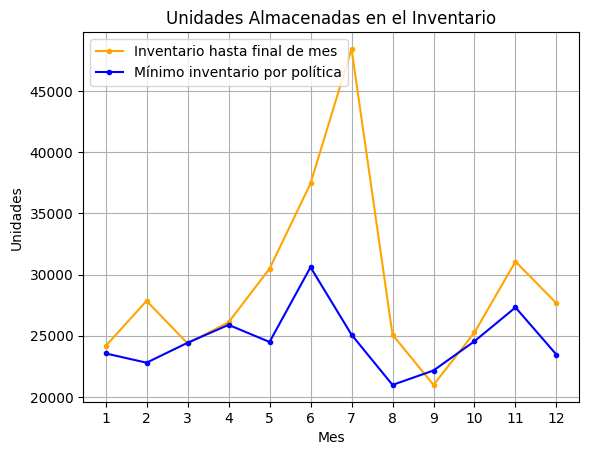

In [ ]:
# Check the lengths of the arrays
print(len(PERIODSt), len(Inventory_per_month))

# Adjust the data or the plotting range accordingly.
# For example, if you are sure Inventory_per_month should have 12 elements:
#Inventory_per_month = Inventory_per_month[:13]  # Trim the list  <- This line is incorrect, it should be slicing to 12 elements, not 13.
Inventory_per_month = Inventory_per_month[:12] # Fix: Trim the list to have 12 elements
# or if PERIODSt is missing a value: # Add the missing period

# Now plot the data
plt.plot(PERIODSt[:12], Inventory_per_month, 'r.-',label = 'Inventario hasta final de mes', c = 'orange') # Also slice PERIODSt to 12 elements to match
plt.plot(PERIODSt[:12], Minimum_with_policy, 'r.-',label = 'Mínimo inventario por política', c = 'blue')

plt.title('Unidades Almacenadas en el Inventario')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
#We are going to analyze production
Production_Model1 = df1[df1['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t' in Name_Decision_Variable)]
Production_Model1

,Name_Decision_Variable,Value_Decision_Variable
74,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_1,32126.0
78,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_2,27936.0
79,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_3,32126.0
80,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_4,36945.0
81,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_5,40158.0
82,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_6,40158.0
83,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_7,17460.0
84,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_8,27936.0
85,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_9,32266.0
75,Unidades_producidas_por_los_operarios_y_recursos_CB_en_tiempo_regular_en_mes_t_10,35339.0


In [ ]:
#We are going to analyze extra hours
Extra_Hours_Model1 = df1[df1['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_producidas_con_horas_extras_durante_el_mes_t' in Name_Decision_Variable)]
Extra_Hours_Model1

,Name_Decision_Variable,Value_Decision_Variable
62,Unidades_producidas_con_horas_extras_durante_el_mes_t_1,0.0
66,Unidades_producidas_con_horas_extras_durante_el_mes_t_2,0.0
67,Unidades_producidas_con_horas_extras_durante_el_mes_t_3,0.0
68,Unidades_producidas_con_horas_extras_durante_el_mes_t_4,0.0
69,Unidades_producidas_con_horas_extras_durante_el_mes_t_5,1325.0
70,Unidades_producidas_con_horas_extras_durante_el_mes_t_6,3492.0
71,Unidades_producidas_con_horas_extras_durante_el_mes_t_7,0.0
72,Unidades_producidas_con_horas_extras_durante_el_mes_t_8,0.0
73,Unidades_producidas_con_horas_extras_durante_el_mes_t_9,0.0
63,Unidades_producidas_con_horas_extras_durante_el_mes_t_10,0.0


In [ ]:
#We are going to analyze outsourced production
Outsourced_Production_Model1 = df1[df1['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_tercerizadas_durante_el_mes_t' in Name_Decision_Variable)]
Outsourced_Production_Model1

,Name_Decision_Variable,Value_Decision_Variable
86,Unidades_tercerizadas_durante_el_mes_t_1,0.0
90,Unidades_tercerizadas_durante_el_mes_t_2,0.0
91,Unidades_tercerizadas_durante_el_mes_t_3,0.0
92,Unidades_tercerizadas_durante_el_mes_t_4,0.0
93,Unidades_tercerizadas_durante_el_mes_t_5,0.0
94,Unidades_tercerizadas_durante_el_mes_t_6,0.0
95,Unidades_tercerizadas_durante_el_mes_t_7,0.0
96,Unidades_tercerizadas_durante_el_mes_t_8,1411.0
97,Unidades_tercerizadas_durante_el_mes_t_9,0.0
87,Unidades_tercerizadas_durante_el_mes_t_10,0.0


In [ ]:
#Lists
Production_per_month = list(Production_Model1['Value_Decision_Variable'])
Extra_Hours_per_month = list(Extra_Hours_Model1['Value_Decision_Variable'])
Outsourced_Production_per_month = list(Outsourced_Production_Model1['Value_Decision_Variable'])

<ipython-input-37-1c43ebd0eda6>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Production_per_month, 'r.-',label = 'UP en tiempo regular', c = 'red')
<ipython-input-37-1c43ebd0eda6>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Extra_Hours_per_month, 'r.-',label = 'UP en tiempo extra', c = 'blue')
<ipython-input-37-1c43ebd0eda6>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Outsourced_Production_per_month, 'r.-',label = 'unidades subcontratadas', c = 'green')


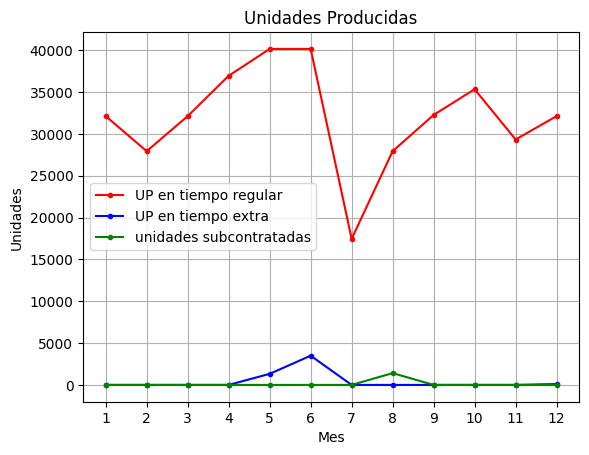

In [ ]:
# Assuming PERIODSt should also have 12 elements, representing 12 months
PERIODSt = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

plt.plot(PERIODSt, Production_per_month, 'r.-',label = 'UP en tiempo regular', c = 'red')
plt.plot(PERIODSt, Extra_Hours_per_month, 'r.-',label = 'UP en tiempo extra', c = 'blue')
plt.plot(PERIODSt, Outsourced_Production_per_month, 'r.-',label = 'unidades subcontratadas', c = 'green')

plt.title('Unidades Producidas')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid()
plt.legend(loc = 'best')

## Scenarios ##

### Scenario 1 ###

First of all, the restriction of the inventory policy will be made more flexible in order to analyze if removing this measure reduces costs considerably. As can be seen, the costs of shortages are one of the highest, but it will be considered from the model if there is any way to minimize more costs simply by changing policies.

In [ ]:
# Setting the scenario
scenario1 = LpProblem("Aggregate_Production_Planning", LpMinimize)

In [ ]:
#Decision Variables
Xt = LpVariable.dicts("Unidades producidas por los operarios y recursos CB en tiempo regular en mes t",t, lowBound = 0, cat = "Integer")
Ht = LpVariable.dicts("Operarios contratados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Lt = LpVariable.dicts("Operarios desvinculados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Wt = LpVariable.dicts("Operarios trabajando durante el mes t",t, lowBound = 0, cat = "Integer")
It = LpVariable.dicts("Unidades en inventario al final del mes t",t, lowBound = 0, cat = "Integer")
St = LpVariable.dicts("Unidades tercerizadas durante el mes t",t, lowBound = 0, cat = "Integer")
Et = LpVariable.dicts("Unidades producidas con horas extras durante el mes t",t, lowBound = 0, cat = "Integer")
Vt = LpVariable.dicts("Unidades vendidas durante el mes t",t, lowBound = 0, cat = "Integer")
Ft = LpVariable.dicts("Unidades faltantes del mes t", t, cat = "Integer")

In [ ]:
#Objective Function
scenario1 += lpSum(alpha*Xt[i] for i in t[1:13]) + lpSum((alpha+(epsilon / r))*Et[i] for i in t[1:13]) + lpSum(delta * St[i] for i in t[1:13]) + lpSum(u * It[i] for i in t[1:13]) + lpSum(phi * (Dt[i]-Vt[i]) for i in t[1:13]) + lpSum(theta * Wt[i] for i in t[1:13]) + lpSum(pi * Lt[i] for i in t[1:13]) + lpSum(gamma * Ht[i] for i in t[1:13])

In [ ]:
#Contraints
It[0] = 24152
Wt[0] = 21

for i in t[1:13]:
  scenario1 += (It[i-1] + Xt[i] + Et[i] + St[i] - Vt[i]) == It[i] # Inventory Balance Equation
#for i in t[1:13]:
  #scenario1 += c*Dt[i+1] <= It[i] #Policy Constraint - Removed
for i in t[1:13]:
  scenario1 += (Wt[i-1] + Ht[i] - Lt[i]) == Wt[i] #Work Balance Equation
for i in t[1:13]:
  scenario1 += Xt[i] <= (r * betha * Nt[i] * ((Wt[i-1] - Lt[i]) + miu * Ht[i]))  #Monthly Production Capacity regular hour MO
for i in t[1:13]:
  scenario1 += p * Xt[i] <= g * k * betha * Mt[i] #Monthly production capacity regular hour MO in bottleneck resource
for i in t[1:13]:
  scenario1 += Et[i] <= (r * TAOt[i] * (Wt[i-1] - Lt[i])) #Production capacity overtime MO
for i in t[1:13]:
  scenario1 += p * Et[i] <= (g * k * LAMBDAt[i]) #Production Capacity Overtime Bottleneck
for i in t[1:13]:
  scenario1 += St[i] <= SIGMAt[i] #Outsourcing capacity
for i in t[1:13]:
  scenario1 += Vt[i] <= Dt[i]  # Sales Limited by Demand
for i in t[1:13]:
  scenario1 += Dt[i] - Vt[i] == Ft[i] #Shortage Equation

In [ ]:
scenario1.solve()
print("Solution Status = ", LpStatus[scenario1.status])

Solution Status =  Optimal


In [ ]:
Name_Variables1 = []
Solution_Variables1 = []
for v in scenario1.variables():
  C = v.name
  D = v.varValue
  print(v.name, "=", v.varValue)
  Name_Variables1.append(C)
  Solution_Variables1.append(D)

Operarios_contratados_a_inicio_del_mes_t_1 = 0.0
Operarios_contratados_a_inicio_del_mes_t_10 = 0.0
Operarios_contratados_a_inicio_del_mes_t_11 = 0.0
Operarios_contratados_a_inicio_del_mes_t_12 = 0.0
Operarios_contratados_a_inicio_del_mes_t_2 = 0.0
Operarios_contratados_a_inicio_del_mes_t_3 = 2.0
Operarios_contratados_a_inicio_del_mes_t_4 = 10.0
Operarios_contratados_a_inicio_del_mes_t_5 = 0.0
Operarios_contratados_a_inicio_del_mes_t_6 = 0.0
Operarios_contratados_a_inicio_del_mes_t_7 = 0.0
Operarios_contratados_a_inicio_del_mes_t_8 = 0.0
Operarios_contratados_a_inicio_del_mes_t_9 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_1 = 7.0
Operarios_desvinculados_a_inicio_del_mes_t_10 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_11 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_12 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_2 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_3 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_4 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_5 = 0

In [ ]:
# Goal Function
print("Cost Function is $", value(scenario1.objective))

Cost Function is $ 3337.6749215044674


In [ ]:
list_of_tuples1 = list(zip(Name_Variables1, Solution_Variables1))
dff1 = pd.DataFrame(list_of_tuples1, columns = ['Name_Decision_Variable', 'Value_Decision_Variable'])
dff1['letter'] = dff1.Name_Decision_Variable.apply(lambda x: x[:-2])
dff1['number'] = dff1.Name_Decision_Variable.apply(lambda x: int(x[-1:]))
dff1 = dff1.sort_values(by=['letter', 'number'])
dff11 = dff1[['Name_Decision_Variable', 'Value_Decision_Variable']]
dff11

,Name_Decision_Variable,Value_Decision_Variable
0,Operarios_contratados_a_inicio_del_mes_t_1,0.0
4,Operarios_contratados_a_inicio_del_mes_t_2,0.0
5,Operarios_contratados_a_inicio_del_mes_t_3,2.0
6,Operarios_contratados_a_inicio_del_mes_t_4,10.0
7,Operarios_contratados_a_inicio_del_mes_t_5,0.0
8,Operarios_contratados_a_inicio_del_mes_t_6,0.0
9,Operarios_contratados_a_inicio_del_mes_t_7,0.0
10,Operarios_contratados_a_inicio_del_mes_t_8,0.0
11,Operarios_contratados_a_inicio_del_mes_t_9,0.0
1,Operarios_contratados_a_inicio_del_mes_t_10,0.0


In [ ]:
# We are going to analize if we met the demand
Sales_model2 = dff11[dff11['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_vendidas_durante_el_mes_t' in Name_Decision_Variable)]
Sales_model2['Monthly_Demand'] = DEMANDt
Sales_per_month2 = list(Sales_model2['Value_Decision_Variable'])
Sales_model2

<ipython-input-46-b2b19cae15fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_model2['Monthly_Demand'] = DEMANDt


,Name_Decision_Variable,Value_Decision_Variable,Monthly_Demand
96,Unidades_vendidas_durante_el_mes_t_1,28430.0,28430
100,Unidades_vendidas_durante_el_mes_t_2,31410.0,31410
101,Unidades_vendidas_durante_el_mes_t_3,30400.0,30400
102,Unidades_vendidas_durante_el_mes_t_4,32570.0,32570
103,Unidades_vendidas_durante_el_mes_t_5,34520.0,34520
104,Unidades_vendidas_durante_el_mes_t_6,32660.0,32660
105,Unidades_vendidas_durante_el_mes_t_7,40800.0,40800
106,Unidades_vendidas_durante_el_mes_t_8,33450.0,33450
107,Unidades_vendidas_durante_el_mes_t_9,27980.0,27980
97,Unidades_vendidas_durante_el_mes_t_10,29550.0,29550


<ipython-input-47-0db4a6f6107b>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
<ipython-input-47-0db4a6f6107b>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Sales_per_month2, 'r.-', label = 'Ventas', c = 'green')


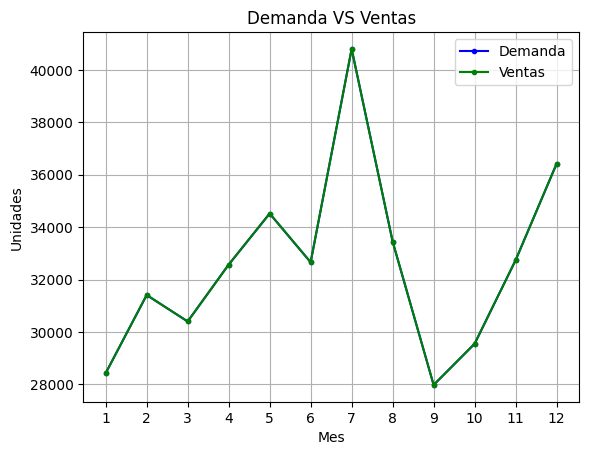

In [ ]:
plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
plt.plot(PERIODSt, Sales_per_month2, 'r.-', label = 'Ventas', c = 'green')

plt.title('Demanda VS Ventas')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Work_Force2 = dff11[dff11['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Operarios_trabajando_durante_el_mes_t' in Name_Decision_Variable)]
Work_Force2

,Name_Decision_Variable,Value_Decision_Variable
24,Operarios_trabajando_durante_el_mes_t_1,14.0
28,Operarios_trabajando_durante_el_mes_t_2,14.0
29,Operarios_trabajando_durante_el_mes_t_3,16.0
30,Operarios_trabajando_durante_el_mes_t_4,26.0
31,Operarios_trabajando_durante_el_mes_t_5,26.0
32,Operarios_trabajando_durante_el_mes_t_6,26.0
33,Operarios_trabajando_durante_el_mes_t_7,26.0
34,Operarios_trabajando_durante_el_mes_t_8,26.0
35,Operarios_trabajando_durante_el_mes_t_9,21.0
25,Operarios_trabajando_durante_el_mes_t_10,21.0


<ipython-input-49-f2e0d602a4b0>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Work_Force_per_month2, 'r.-',label = 'Operarios sin política', c = 'red')
<ipython-input-49-f2e0d602a4b0>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Work_Force_per_month, 'r.-',label = 'Operarios con política', c = 'green')


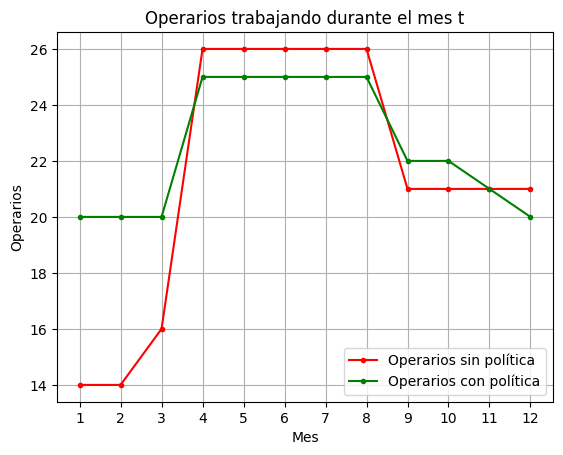

In [ ]:
Work_Force_per_month2 = list(Work_Force2['Value_Decision_Variable'])
plt.plot(PERIODSt, Work_Force_per_month2, 'r.-',label = 'Operarios sin política', c = 'red')
plt.plot(PERIODSt, Work_Force_per_month, 'r.-',label = 'Operarios con política', c = 'green')

plt.title('Operarios trabajando durante el mes t')
plt.xlabel('Mes')
plt.ylabel('Operarios')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Inventory_Model2 = dff11[dff11['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_en_inventario_al_final_del_mes_t' in Name_Decision_Variable)]
Inventory_Model2

,Name_Decision_Variable,Value_Decision_Variable
36,Unidades_en_inventario_al_final_del_mes_t_1,18210.0
40,Unidades_en_inventario_al_final_del_mes_t_2,6355.0
41,Unidades_en_inventario_al_final_del_mes_t_3,371.0
42,Unidades_en_inventario_al_final_del_mes_t_4,3140.0
43,Unidades_en_inventario_al_final_del_mes_t_5,11304.0
44,Unidades_en_inventario_al_final_del_mes_t_6,24039.0
45,Unidades_en_inventario_al_final_del_mes_t_7,1397.0
46,Unidades_en_inventario_al_final_del_mes_t_8,0.0
47,Unidades_en_inventario_al_final_del_mes_t_9,1914.0
37,Unidades_en_inventario_al_final_del_mes_t_10,6096.0


In [ ]:
Shortages_Model2 = dff11[dff11['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_faltantes_del_mes_t' in Name_Decision_Variable)]
Shortages_Model2

,Name_Decision_Variable,Value_Decision_Variable
48,Unidades_faltantes_del_mes_t_1,0.0
52,Unidades_faltantes_del_mes_t_2,0.0
53,Unidades_faltantes_del_mes_t_3,0.0
54,Unidades_faltantes_del_mes_t_4,0.0
55,Unidades_faltantes_del_mes_t_5,0.0
56,Unidades_faltantes_del_mes_t_6,0.0
57,Unidades_faltantes_del_mes_t_7,0.0
58,Unidades_faltantes_del_mes_t_8,0.0
59,Unidades_faltantes_del_mes_t_9,0.0
49,Unidades_faltantes_del_mes_t_10,0.0


In [ ]:
Inventory_per_month2 = list(Inventory_Model2['Value_Decision_Variable'])
Shortages_per_month2 = list(Shortages_Model2['Value_Decision_Variable'])

<ipython-input-53-94e1b60f55ad>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Inventory_per_month2, 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
<ipython-input-53-94e1b60f55ad>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Shortages_per_month2, 'r.-',label = 'Faltantes en el mes', c = 'blue')


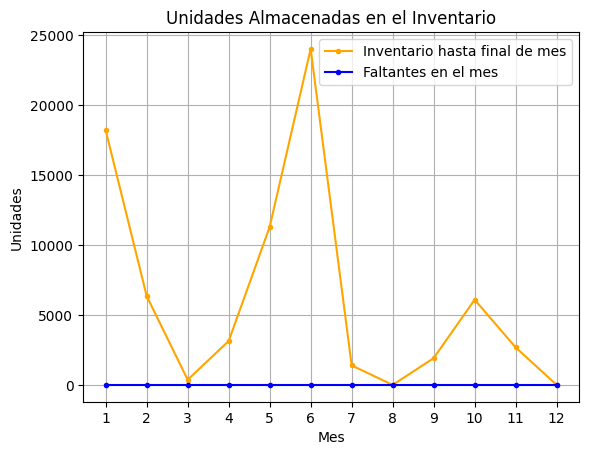

In [ ]:
plt.plot(PERIODSt, Inventory_per_month2, 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
plt.plot(PERIODSt, Shortages_per_month2, 'r.-',label = 'Faltantes en el mes', c = 'blue')

plt.title('Unidades Almacenadas en el Inventario')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

## Scenario 2 ##

Shortages are still not incurred because it is less costly to produce and meet demand under the given conditions. However, there is something to highlight: the model without policy claims that a lot of labor can easily be hired for critical moments, which is not realistic. In this new scenario, the restriction is added that no more than 3 people can be hired in a month and no more than 4 people can be fired so as not to strain the work environment. It will be observed what decisions the model indicates.

In [ ]:
# Setting the scenario
scenario2 = LpProblem("Aggregate_Production_Planning", LpMinimize)

In [ ]:
#Decision Variables
Xt = LpVariable.dicts("Unidades producidas por los operarios y recursos CB en tiempo regular en mes t",t, lowBound = 0, cat = "Integer")
Ht = LpVariable.dicts("Operarios contratados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Lt = LpVariable.dicts("Operarios desvinculados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Wt = LpVariable.dicts("Operarios trabajando durante el mes t",t, lowBound = 0, cat = "Integer")
It = LpVariable.dicts("Unidades en inventario al final del mes t",t, lowBound = 0, cat = "Integer")
St = LpVariable.dicts("Unidades tercerizadas durante el mes t",t, lowBound = 0, cat = "Integer")
Et = LpVariable.dicts("Unidades producidas con horas extras durante el mes t",t, lowBound = 0, cat = "Integer")
Vt = LpVariable.dicts("Unidades vendidas durante el mes t",t, lowBound = 0, cat = "Integer")
Ft = LpVariable.dicts("Unidades faltantes del mes t", t,  cat = "Integer")

In [ ]:
#New hires now underperform in their first month
miu = 0.45

In [ ]:
#Objective Function
scenario2 += lpSum(alpha*Xt[i] for i in t[1:13]) + lpSum((alpha+(epsilon / r))*Et[i] for i in t[1:13]) + lpSum(delta * St[i] for i in t[1:13]) + lpSum(u * It[i] for i in t[1:13]) + lpSum(phi * (Dt[i]-Vt[i]) for i in t[1:13]) + lpSum(theta * Wt[i] for i in t[1:13]) + lpSum(pi * Lt[i] for i in t[1:13]) + lpSum(gamma * Ht[i] for i in t[1:13])

In [ ]:
#Contraints
It[0] = 24152
Wt[0] = 21

for i in t[1:13]:
  scenario2 += (It[i-1] + Xt[i] + Et[i] + St[i] - Vt[i]) == It[i] # Inventory Balance Equation
#for i in t[1:13]:
  #scenario1 += c*Dt[i+1] <= It[i] #Policy Constraint - Removed
for i in t[1:13]:
  scenario2 += (Wt[i-1] + Ht[i] - Lt[i]) == Wt[i] #Work Balance Equation
for i in t[1:13]:
  scenario2 += Xt[i] <= (r * betha * Nt[i] * ((Wt[i-1] - Lt[i]) + miu * Ht[i]))  #Monthly Production Capacity regular hour MO
for i in t[1:13]:
  scenario2 += p * Xt[i] <= g * k * betha * Mt[i] #Monthly production capacity regular hour MO in bottleneck resource
for i in t[1:13]:
  scenario2 += Et[i] <= (r * TAOt[i] * (Wt[i-1] - Lt[i])) #Production capacity overtime MO
for i in t[1:13]:
  scenario2 += p * Et[i] <= (g * k * LAMBDAt[i]) #Production Capacity Overtime Bottleneck
for i in t[1:13]:
  scenario2 += St[i] <= SIGMAt[i] #Outsourcing capacity
for i in t[1:13]:
  scenario2 += Vt[i] <= Dt[i]  # Sales Limited by Demand
for i in t[1:13]:
  scenario2 += Dt[i] - Vt[i] == Ft[i] #Shortage Equation
for i in t[1:13]:
  scenario2 += Ht[i] <= 3 #It is possible just to hire 3 employees by month
for i in t[1:13]:
  scenario2 += Lt[i] <= 4 #It is possible just to fire 4 employees by month

In [ ]:
scenario2.solve()
print("Solution Status = ", LpStatus[scenario2.status])

Solution Status =  Optimal


In [ ]:
Name_Variables2 = []
Solution_Variables2 = []
for v in scenario2.variables():
  E = v.name
  F = v.varValue
  print(v.name, "=", v.varValue)
  Name_Variables2.append(E)
  Solution_Variables2.append(F)

Operarios_contratados_a_inicio_del_mes_t_1 = 0.0
Operarios_contratados_a_inicio_del_mes_t_10 = 0.0
Operarios_contratados_a_inicio_del_mes_t_11 = 0.0
Operarios_contratados_a_inicio_del_mes_t_12 = 0.0
Operarios_contratados_a_inicio_del_mes_t_2 = 0.0
Operarios_contratados_a_inicio_del_mes_t_3 = 3.0
Operarios_contratados_a_inicio_del_mes_t_4 = 3.0
Operarios_contratados_a_inicio_del_mes_t_5 = 0.0
Operarios_contratados_a_inicio_del_mes_t_6 = 0.0
Operarios_contratados_a_inicio_del_mes_t_7 = 0.0
Operarios_contratados_a_inicio_del_mes_t_8 = 0.0
Operarios_contratados_a_inicio_del_mes_t_9 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_1 = 4.0
Operarios_desvinculados_a_inicio_del_mes_t_10 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_11 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_12 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_2 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_3 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_4 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_5 = 0.

In [ ]:
# Goal Function
print("Cost Function is $", value(scenario2.objective))

Cost Function is $ 3345.7677948349387


In [ ]:
list_of_tuples2 = list(zip(Name_Variables2, Solution_Variables2))
dff2 = pd.DataFrame(list_of_tuples2, columns = ['Name_Decision_Variable', 'Value_Decision_Variable'])
dff2['letter'] = dff2.Name_Decision_Variable.apply(lambda x: x[:-2])
dff2['number'] = dff2.Name_Decision_Variable.apply(lambda x: int(x[-1:]))
dff2 = dff2.sort_values(by=['letter', 'number'])
dff22 = dff2[['Name_Decision_Variable', 'Value_Decision_Variable']]
dff22

,Name_Decision_Variable,Value_Decision_Variable
0,Operarios_contratados_a_inicio_del_mes_t_1,0.0
4,Operarios_contratados_a_inicio_del_mes_t_2,0.0
5,Operarios_contratados_a_inicio_del_mes_t_3,3.0
6,Operarios_contratados_a_inicio_del_mes_t_4,3.0
7,Operarios_contratados_a_inicio_del_mes_t_5,0.0
8,Operarios_contratados_a_inicio_del_mes_t_6,0.0
9,Operarios_contratados_a_inicio_del_mes_t_7,0.0
10,Operarios_contratados_a_inicio_del_mes_t_8,0.0
11,Operarios_contratados_a_inicio_del_mes_t_9,0.0
1,Operarios_contratados_a_inicio_del_mes_t_10,0.0


In [ ]:
# We are going to analize if we met the demand
Sales_model3 = dff22[dff22['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_vendidas_durante_el_mes_t' in Name_Decision_Variable)]
Sales_model3['Monthly_Demand'] = DEMANDt
Sales_per_month3 = list(Sales_model3['Value_Decision_Variable'])
Sales_model3

<ipython-input-63-93189e7b45dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_model3['Monthly_Demand'] = DEMANDt


,Name_Decision_Variable,Value_Decision_Variable,Monthly_Demand
96,Unidades_vendidas_durante_el_mes_t_1,28430.0,28430
100,Unidades_vendidas_durante_el_mes_t_2,31410.0,31410
101,Unidades_vendidas_durante_el_mes_t_3,30400.0,30400
102,Unidades_vendidas_durante_el_mes_t_4,32570.0,32570
103,Unidades_vendidas_durante_el_mes_t_5,34520.0,34520
104,Unidades_vendidas_durante_el_mes_t_6,32660.0,32660
105,Unidades_vendidas_durante_el_mes_t_7,40800.0,40800
106,Unidades_vendidas_durante_el_mes_t_8,33450.0,33450
107,Unidades_vendidas_durante_el_mes_t_9,27980.0,27980
97,Unidades_vendidas_durante_el_mes_t_10,29550.0,29550


<ipython-input-64-b73b1f3582f8>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
<ipython-input-64-b73b1f3582f8>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Sales_per_month3, 'r.-', label = 'Ventas', c = 'green')


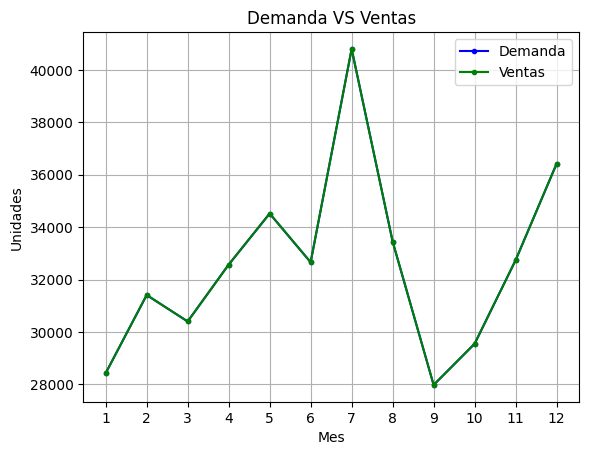

In [ ]:
plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
plt.plot(PERIODSt, Sales_per_month3, 'r.-', label = 'Ventas', c = 'green')

plt.title('Demanda VS Ventas')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Work_Force3 = dff22[dff22['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Operarios_trabajando_durante_el_mes_t' in Name_Decision_Variable)]
Work_Force3

,Name_Decision_Variable,Value_Decision_Variable
24,Operarios_trabajando_durante_el_mes_t_1,17.0
28,Operarios_trabajando_durante_el_mes_t_2,17.0
29,Operarios_trabajando_durante_el_mes_t_3,20.0
30,Operarios_trabajando_durante_el_mes_t_4,23.0
31,Operarios_trabajando_durante_el_mes_t_5,23.0
32,Operarios_trabajando_durante_el_mes_t_6,23.0
33,Operarios_trabajando_durante_el_mes_t_7,23.0
34,Operarios_trabajando_durante_el_mes_t_8,23.0
35,Operarios_trabajando_durante_el_mes_t_9,21.0
25,Operarios_trabajando_durante_el_mes_t_10,21.0


<ipython-input-66-016111699172>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Work_Force_per_month3, 'r.-',label = 'Operarios con restricción', c = 'red')
<ipython-input-66-016111699172>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Work_Force_per_month, 'r.-',label = 'Operarios con política', c = 'green')


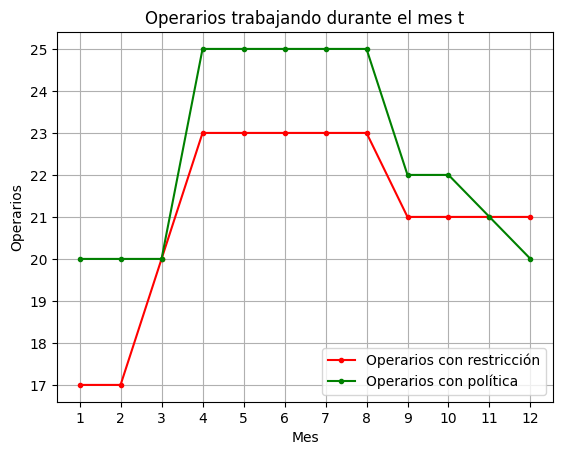

In [ ]:
Work_Force_per_month3 = list(Work_Force3['Value_Decision_Variable'])
plt.plot(PERIODSt, Work_Force_per_month3, 'r.-',label = 'Operarios con restricción', c = 'red')
plt.plot(PERIODSt, Work_Force_per_month, 'r.-',label = 'Operarios con política', c = 'green')

plt.title('Operarios trabajando durante el mes t')
plt.xlabel('Mes')
plt.ylabel('Operarios')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Inventory_Model3 = dff22[dff22['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_en_inventario_al_final_del_mes_t' in Name_Decision_Variable)]
Inventory_Model3

,Name_Decision_Variable,Value_Decision_Variable
36,Unidades_en_inventario_al_final_del_mes_t_1,23029.0
40,Unidades_en_inventario_al_final_del_mes_t_2,15364.0
41,Unidades_en_inventario_al_final_del_mes_t_3,14439.0
42,Unidades_en_inventario_al_final_del_mes_t_4,16163.0
43,Unidades_en_inventario_al_final_del_mes_t_5,21800.0
44,Unidades_en_inventario_al_final_del_mes_t_6,29297.0
45,Unidades_en_inventario_al_final_del_mes_t_7,4749.0
46,Unidades_en_inventario_al_final_del_mes_t_8,0.0
47,Unidades_en_inventario_al_final_del_mes_t_9,1914.0
37,Unidades_en_inventario_al_final_del_mes_t_10,6096.0


In [ ]:
Shortages_Model3 = dff22[dff22['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_faltantes_del_mes_t' in Name_Decision_Variable)]
Shortages_Model3

,Name_Decision_Variable,Value_Decision_Variable
48,Unidades_faltantes_del_mes_t_1,0.0
52,Unidades_faltantes_del_mes_t_2,0.0
53,Unidades_faltantes_del_mes_t_3,0.0
54,Unidades_faltantes_del_mes_t_4,0.0
55,Unidades_faltantes_del_mes_t_5,0.0
56,Unidades_faltantes_del_mes_t_6,0.0
57,Unidades_faltantes_del_mes_t_7,0.0
58,Unidades_faltantes_del_mes_t_8,0.0
59,Unidades_faltantes_del_mes_t_9,0.0
49,Unidades_faltantes_del_mes_t_10,0.0


In [ ]:
Inventory_per_month3 = list(Inventory_Model3['Value_Decision_Variable'])
Shortages_per_month3 = list(Shortages_Model3['Value_Decision_Variable'])

<ipython-input-70-ddaa2f6aabb9>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Inventory_per_month3, 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
<ipython-input-70-ddaa2f6aabb9>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Shortages_per_month3, 'r.-',label = 'Faltantes en el mes', c = 'blue')


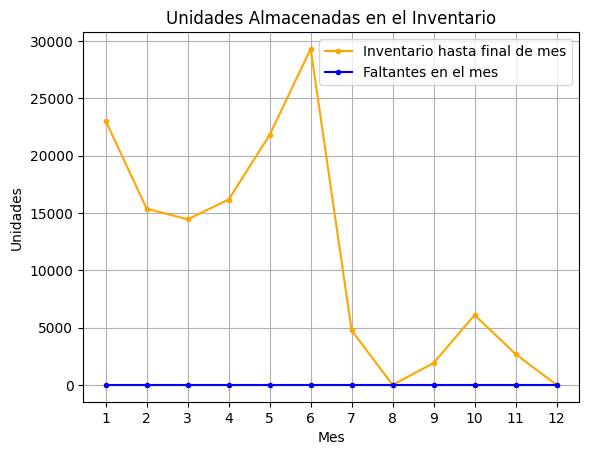

In [ ]:
plt.plot(PERIODSt, Inventory_per_month3, 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
plt.plot(PERIODSt, Shortages_per_month3, 'r.-',label = 'Faltantes en el mes', c = 'blue')

plt.title('Unidades Almacenadas en el Inventario')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

## Scenario 3 ##

In order to analyze how the model will respond to demand, we will seek to obtain optimal inventory management from the level strategy. Additional personnel will not be hired, so that in this way it can be seen what other strategies the company can have when executing production.

In [ ]:
# Setting the scenario
scenario3 = LpProblem("Aggregate_Production_Planning", LpMinimize)

In [ ]:
#Decision Variables
Xt = LpVariable.dicts("Unidades producidas por los operarios y recursos CB en tiempo regular en mes t",t, lowBound = 0, cat = "Integer")
It = LpVariable.dicts("Unidades en inventario al final del mes t",t, lowBound = 0, cat = "Integer")
St = LpVariable.dicts("Unidades tercerizadas durante el mes t",t, lowBound = 0, cat = "Integer")
Et = LpVariable.dicts("Unidades producidas con horas extras durante el mes t",t, lowBound = 0, cat = "Integer")
Vt = LpVariable.dicts("Unidades vendidas durante el mes t",t, lowBound = 0, cat = "Integer")
Ft = LpVariable.dicts("Unidades faltantes del mes t", t,  cat = "Integer")

In [ ]:
#Objective Function
scenario3 += lpSum(alpha*Xt[i] for i in t[1:13]) + lpSum((alpha+(epsilon / r))*Et[i] for i in t[1:13]) + lpSum(delta * St[i] for i in t[1:13]) + lpSum(u * It[i] for i in t[1:13]) + lpSum(phi * (Dt[i]-Vt[i]) for i in t[1:13]) + 675.36

In [ ]:
#Contraints
It[0] = 24152
Wt = 21

for i in t[1:13]:
  scenario3 += (It[i-1] + Xt[i] + Et[i] + St[i] - Vt[i]) == It[i] # Inventory Balance Equation
for i in t[1:13]:
  scenario3 += Xt[i] <= r * betha * Nt[i] * Wt  #Monthly Production Capacity regular hour MO
for i in t[1:13]:
  scenario3 += p * Xt[i] <= g * k * betha * Mt[i] #Monthly production capacity regular hour MO in bottleneck resource
for i in t[1:13]:
  scenario3 += Et[i] <= r * TAOt[i] * Wt #Production capacity overtime MO
for i in t[1:13]:
  scenario3 += p * Et[i] <= (g * k * LAMBDAt[i]) #Production Capacity Overtime Bottleneck
for i in t[1:13]:
  scenario3 += St[i] <= SIGMAt[i] #Outsourcing capacity
for i in t[1:13]:
  scenario3 += Vt[i] <= Dt[i]  # Sales Limited by Demand
for i in t[1:13]:
  scenario3 += Dt[i] - Vt[i] == Ft[i] #Shortage Equation

In [ ]:
scenario3.solve()
print("Solution Status = ", LpStatus[scenario3.status])

Solution Status =  Optimal


In [ ]:
Name_Variables3 = []
Solution_Variables3 = []
for v in scenario3.variables():
  G = v.name
  H = v.varValue
  print(v.name, "=", v.varValue)
  Name_Variables3.append(G)
  Solution_Variables3.append(H)

Unidades_en_inventario_al_final_del_mes_t_1 = 27485.0
Unidades_en_inventario_al_final_del_mes_t_10 = 6096.0
Unidades_en_inventario_al_final_del_mes_t_11 = 2688.0
Unidades_en_inventario_al_final_del_mes_t_12 = 0.0
Unidades_en_inventario_al_final_del_mes_t_2 = 25407.0
Unidades_en_inventario_al_final_del_mes_t_3 = 28739.0
Unidades_en_inventario_al_final_del_mes_t_4 = 29901.0
Unidades_en_inventario_al_final_del_mes_t_5 = 29113.0
Unidades_en_inventario_al_final_del_mes_t_6 = 33118.0
Unidades_en_inventario_al_final_del_mes_t_7 = 6984.0
Unidades_en_inventario_al_final_del_mes_t_8 = 0.0
Unidades_en_inventario_al_final_del_mes_t_9 = 1914.0
Unidades_faltantes_del_mes_t_1 = 0.0
Unidades_faltantes_del_mes_t_10 = 0.0
Unidades_faltantes_del_mes_t_11 = 0.0
Unidades_faltantes_del_mes_t_12 = 0.0
Unidades_faltantes_del_mes_t_2 = 0.0
Unidades_faltantes_del_mes_t_3 = 0.0
Unidades_faltantes_del_mes_t_4 = 0.0
Unidades_faltantes_del_mes_t_5 = 0.0
Unidades_faltantes_del_mes_t_6 = 0.0
Unidades_faltantes_del_me

In [ ]:
# Goal Function
print("Cost Function is $", value(scenario3.objective))

Cost Function is $ 3349.5321087107677


In [ ]:
list_of_tuples3 = list(zip(Name_Variables3, Solution_Variables3))
dff3 = pd.DataFrame(list_of_tuples3, columns = ['Name_Decision_Variable', 'Value_Decision_Variable'])
dff3['letter'] = dff3.Name_Decision_Variable.apply(lambda x: x[:-2])
dff3['number'] = dff3.Name_Decision_Variable.apply(lambda x: int(x[-1:]))
dff3 = dff3.sort_values(by=['letter', 'number'])
dff33 = dff3[['Name_Decision_Variable', 'Value_Decision_Variable']]
dff33

,Name_Decision_Variable,Value_Decision_Variable
0,Unidades_en_inventario_al_final_del_mes_t_1,27485.0
4,Unidades_en_inventario_al_final_del_mes_t_2,25407.0
5,Unidades_en_inventario_al_final_del_mes_t_3,28739.0
6,Unidades_en_inventario_al_final_del_mes_t_4,29901.0
7,Unidades_en_inventario_al_final_del_mes_t_5,29113.0
8,Unidades_en_inventario_al_final_del_mes_t_6,33118.0
9,Unidades_en_inventario_al_final_del_mes_t_7,6984.0
10,Unidades_en_inventario_al_final_del_mes_t_8,0.0
11,Unidades_en_inventario_al_final_del_mes_t_9,1914.0
1,Unidades_en_inventario_al_final_del_mes_t_10,6096.0


In [ ]:
# We are going to analize if we met the demand
Sales_model4 = dff33[dff33['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_vendidas_durante_el_mes_t' in Name_Decision_Variable)]
Sales_model4['Monthly_Demand'] = DEMANDt
Sales_per_month4 = list(Sales_model4['Value_Decision_Variable'])
Sales_model4

<ipython-input-79-01594a93dd34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_model4['Monthly_Demand'] = DEMANDt


,Name_Decision_Variable,Value_Decision_Variable,Monthly_Demand
60,Unidades_vendidas_durante_el_mes_t_1,28430.0,28430
64,Unidades_vendidas_durante_el_mes_t_2,31410.0,31410
65,Unidades_vendidas_durante_el_mes_t_3,30400.0,30400
66,Unidades_vendidas_durante_el_mes_t_4,32570.0,32570
67,Unidades_vendidas_durante_el_mes_t_5,34520.0,34520
68,Unidades_vendidas_durante_el_mes_t_6,32660.0,32660
69,Unidades_vendidas_durante_el_mes_t_7,40800.0,40800
70,Unidades_vendidas_durante_el_mes_t_8,33450.0,33450
71,Unidades_vendidas_durante_el_mes_t_9,27980.0,27980
61,Unidades_vendidas_durante_el_mes_t_10,29550.0,29550


<ipython-input-80-6023136cdd18>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
<ipython-input-80-6023136cdd18>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Sales_per_month4, 'r.-', label = 'Ventas', c = 'green')


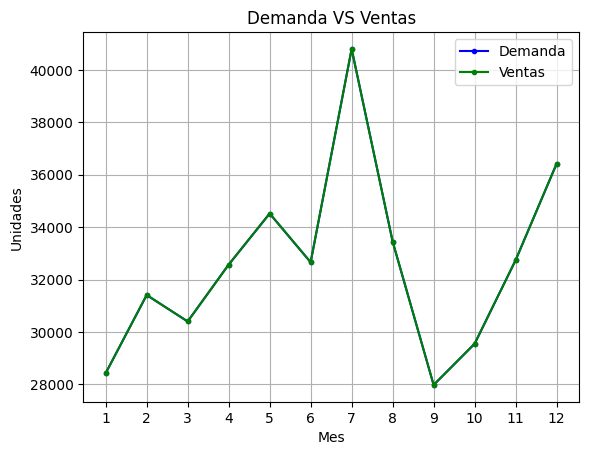

In [ ]:
plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
plt.plot(PERIODSt, Sales_per_month4, 'r.-', label = 'Ventas', c = 'green')

plt.title('Demanda VS Ventas')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Inventory_Model4 = dff33[dff33['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_en_inventario_al_final_del_mes_t' in Name_Decision_Variable)]
Inventory_Model4

,Name_Decision_Variable,Value_Decision_Variable
0,Unidades_en_inventario_al_final_del_mes_t_1,27485.0
4,Unidades_en_inventario_al_final_del_mes_t_2,25407.0
5,Unidades_en_inventario_al_final_del_mes_t_3,28739.0
6,Unidades_en_inventario_al_final_del_mes_t_4,29901.0
7,Unidades_en_inventario_al_final_del_mes_t_5,29113.0
8,Unidades_en_inventario_al_final_del_mes_t_6,33118.0
9,Unidades_en_inventario_al_final_del_mes_t_7,6984.0
10,Unidades_en_inventario_al_final_del_mes_t_8,0.0
11,Unidades_en_inventario_al_final_del_mes_t_9,1914.0
1,Unidades_en_inventario_al_final_del_mes_t_10,6096.0


In [ ]:
Shortages_Model4 = dff33[dff33['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_faltantes_del_mes_t' in Name_Decision_Variable)]
Shortages_Model4

,Name_Decision_Variable,Value_Decision_Variable
12,Unidades_faltantes_del_mes_t_1,0.0
16,Unidades_faltantes_del_mes_t_2,0.0
17,Unidades_faltantes_del_mes_t_3,0.0
18,Unidades_faltantes_del_mes_t_4,0.0
19,Unidades_faltantes_del_mes_t_5,0.0
20,Unidades_faltantes_del_mes_t_6,0.0
21,Unidades_faltantes_del_mes_t_7,0.0
22,Unidades_faltantes_del_mes_t_8,0.0
23,Unidades_faltantes_del_mes_t_9,0.0
13,Unidades_faltantes_del_mes_t_10,0.0


In [ ]:
Inventory_per_month4 = list(Inventory_Model4['Value_Decision_Variable'])
Shortages_per_month4 = list(Shortages_Model4['Value_Decision_Variable'])

<ipython-input-84-4c7406e6e765>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Inventory_per_month4, 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
<ipython-input-84-4c7406e6e765>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Shortages_per_month4, 'r.-',label = 'Faltantes en el mes', c = 'blue')


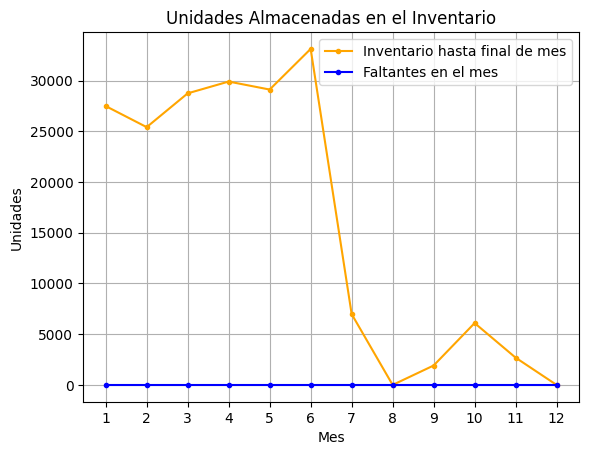

In [ ]:
plt.plot(PERIODSt, Inventory_per_month4, 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
plt.plot(PERIODSt, Shortages_per_month4, 'r.-',label = 'Faltantes en el mes', c = 'blue')

plt.title('Unidades Almacenadas en el Inventario')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

## Scenario 4

As scenario 4, we won´t have the opportunity to outsource. We must use all the capacity that we have to produce and satisfy demand. The scenario is the next,

In [ ]:
# Setting the scenario
scenario4 = LpProblem("Aggregate_Production_Planning", LpMinimize)

In [ ]:
#Decision Variables
Xt = LpVariable.dicts("Unidades producidas por los operarios y recursos CB en tiempo regular en mes t",t, lowBound = 0, cat = "Integer")
Ht = LpVariable.dicts("Operarios contratados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Lt = LpVariable.dicts("Operarios desvinculados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Wt = LpVariable.dicts("Operarios trabajando durante el mes t",t, lowBound = 0, cat = "Integer")
It = LpVariable.dicts("Unidades en inventario al final del mes t",t, lowBound = 0, cat = "Integer")
Et = LpVariable.dicts("Unidades producidas con horas extras durante el mes t",t, lowBound = 0, cat = "Integer")
Vt = LpVariable.dicts("Unidades vendidas durante el mes t",t, lowBound = 0, cat = "Integer")
Ft = LpVariable.dicts("Unidades faltantes del mes t", t, lowBound = 0, cat = "Integer")

In [ ]:
#Objective Function
scenario4 += lpSum(alpha*Xt[i] for i in t[1:13]) + lpSum((alpha+(epsilon / r))*Et[i] for i in t[1:13]) + lpSum(u * It[i] for i in t[1:13]) + lpSum(phi * (Dt[i]-Vt[i]) for i in t[1:13]) + 675.36

In [ ]:
#Contraints
scenario4 += It[0] == 24152
scenario4 += Wt[0] == 21  # Now this should work

for i in t[1:13]:
  scenario4 += (It[i-1] + Xt[i] + Et[i] - Vt[i]) == It[i] # Inventory Balance Equation
for i in t[1:13]:
  scenario4 += (Wt[i-1] + Ht[i] - Lt[i]) == Wt[i] #Work Balance Equation
for i in t[1:13]:
  scenario4 += Xt[i] <= (r * betha * Nt[i] * ((Wt[i-1] - Lt[i]) + miu * Ht[i]))  #Monthly Production Capacity regular hour MO
for i in t[1:13]:
  scenario4 += p * Xt[i] <= g * k * betha * Mt[i] #Monthly production capacity regular hour MO in bottleneck resource
for i in t[1:13]:
  scenario4 += Et[i] <= (r * TAOt[i] * (Wt[i-1] - Lt[i])) #Production capacity overtime MO
for i in t[1:13]:
  scenario4 += p * Et[i] <= (g * k * LAMBDAt[i]) #Production Capacity Overtime Bottleneck
for i in t[1:13]:
  scenario4 += Vt[i] <= Dt[i]  # Sales Limited by Demand
for i in t[1:13]:
  scenario4 += Dt[i] - Vt[i] == Ft[i] #Shortage Equation

In [ ]:
scenario4.solve()
print("Solution Status = ", LpStatus[scenario4.status])

Solution Status =  Optimal


In [ ]:
Name_Variables4 = []
Solution_Variables4 = []
for v in scenario4.variables():
  G = v.name
  H = v.varValue
  print(v.name, "=", v.varValue)
  Name_Variables4.append(G)
  Solution_Variables4.append(H)

Operarios_contratados_a_inicio_del_mes_t_1 = 2.0
Operarios_contratados_a_inicio_del_mes_t_10 = 5.0
Operarios_contratados_a_inicio_del_mes_t_11 = 0.0
Operarios_contratados_a_inicio_del_mes_t_12 = 0.0
Operarios_contratados_a_inicio_del_mes_t_2 = 0.0
Operarios_contratados_a_inicio_del_mes_t_3 = 0.0
Operarios_contratados_a_inicio_del_mes_t_4 = 0.0
Operarios_contratados_a_inicio_del_mes_t_5 = 0.0
Operarios_contratados_a_inicio_del_mes_t_6 = 37.0
Operarios_contratados_a_inicio_del_mes_t_7 = 0.0
Operarios_contratados_a_inicio_del_mes_t_8 = 0.0
Operarios_contratados_a_inicio_del_mes_t_9 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_1 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_10 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_11 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_12 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_2 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_3 = 1.0
Operarios_desvinculados_a_inicio_del_mes_t_4 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_5 = 0

In [ ]:
# Goal Function
print("Cost Function is $", value(scenario4.objective))

Cost Function is $ 3233.6365499999993


In [ ]:
list_of_tuples4 = list(zip(Name_Variables4, Solution_Variables4))
dff4 = pd.DataFrame(list_of_tuples4, columns = ['Name_Decision_Variable', 'Value_Decision_Variable'])
dff4['letter'] = dff4.Name_Decision_Variable.apply(lambda x: x[:-2])
dff4['number'] = dff4.Name_Decision_Variable.apply(lambda x: int(x[-1:]))
dff4 = dff4.sort_values(by=['letter', 'number'])
dff44 = dff4[['Name_Decision_Variable', 'Value_Decision_Variable']]
dff44

,Name_Decision_Variable,Value_Decision_Variable
0,Operarios_contratados_a_inicio_del_mes_t_1,2.0
4,Operarios_contratados_a_inicio_del_mes_t_2,0.0
5,Operarios_contratados_a_inicio_del_mes_t_3,0.0
6,Operarios_contratados_a_inicio_del_mes_t_4,0.0
7,Operarios_contratados_a_inicio_del_mes_t_5,0.0
8,Operarios_contratados_a_inicio_del_mes_t_6,37.0
9,Operarios_contratados_a_inicio_del_mes_t_7,0.0
10,Operarios_contratados_a_inicio_del_mes_t_8,0.0
11,Operarios_contratados_a_inicio_del_mes_t_9,0.0
1,Operarios_contratados_a_inicio_del_mes_t_10,5.0


In [ ]:
# We are going to analize if we met the demand
Sales_model4 = dff44[dff44['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_vendidas_durante_el_mes_t' in Name_Decision_Variable)]
Sales_model4['Monthly_Demand'] = DEMANDt
Sales_per_month4 = list(Sales_model4['Value_Decision_Variable'])
Sales_model4

<ipython-input-93-02435034c0ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_model4['Monthly_Demand'] = DEMANDt


,Name_Decision_Variable,Value_Decision_Variable,Monthly_Demand
86,Unidades_vendidas_durante_el_mes_t_1,28430.0,28430
90,Unidades_vendidas_durante_el_mes_t_2,31410.0,31410
91,Unidades_vendidas_durante_el_mes_t_3,30400.0,30400
92,Unidades_vendidas_durante_el_mes_t_4,32570.0,32570
93,Unidades_vendidas_durante_el_mes_t_5,34520.0,34520
94,Unidades_vendidas_durante_el_mes_t_6,32660.0,32660
95,Unidades_vendidas_durante_el_mes_t_7,40800.0,40800
96,Unidades_vendidas_durante_el_mes_t_8,33450.0,33450
97,Unidades_vendidas_durante_el_mes_t_9,27980.0,27980
87,Unidades_vendidas_durante_el_mes_t_10,29550.0,29550


<ipython-input-94-6023136cdd18>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
<ipython-input-94-6023136cdd18>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Sales_per_month4, 'r.-', label = 'Ventas', c = 'green')


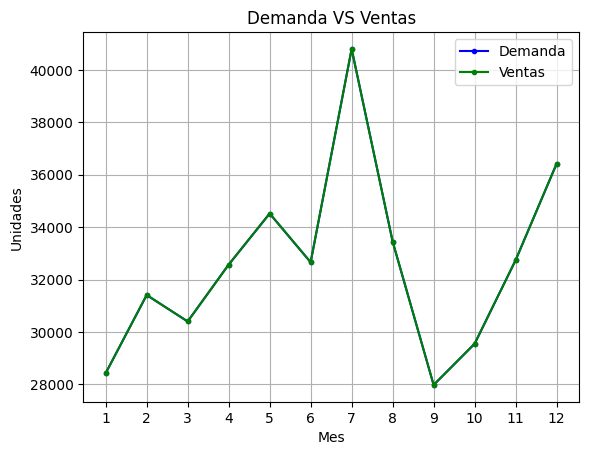

In [ ]:
plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
plt.plot(PERIODSt, Sales_per_month4, 'r.-', label = 'Ventas', c = 'green')

plt.title('Demanda VS Ventas')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Inventory_Model4 = dff44[dff44['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_en_inventario_al_final_del_mes_t' in Name_Decision_Variable)]
Inventory_Model4

,Name_Decision_Variable,Value_Decision_Variable
37,Unidades_en_inventario_al_final_del_mes_t_0,24152.0
38,Unidades_en_inventario_al_final_del_mes_t_1,0.0
42,Unidades_en_inventario_al_final_del_mes_t_2,0.0
43,Unidades_en_inventario_al_final_del_mes_t_3,0.0
44,Unidades_en_inventario_al_final_del_mes_t_4,0.0
45,Unidades_en_inventario_al_final_del_mes_t_5,0.0
46,Unidades_en_inventario_al_final_del_mes_t_6,0.0
47,Unidades_en_inventario_al_final_del_mes_t_7,0.0
48,Unidades_en_inventario_al_final_del_mes_t_8,0.0
49,Unidades_en_inventario_al_final_del_mes_t_9,0.0


In [ ]:
Work_Force4 = dff44[dff44['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Operarios_trabajando_durante_el_mes_t' in Name_Decision_Variable)]
Work_Force4

,Name_Decision_Variable,Value_Decision_Variable
24,Operarios_trabajando_durante_el_mes_t_0,21.0
25,Operarios_trabajando_durante_el_mes_t_1,23.0
29,Operarios_trabajando_durante_el_mes_t_2,23.0
30,Operarios_trabajando_durante_el_mes_t_3,22.0
31,Operarios_trabajando_durante_el_mes_t_4,22.0
32,Operarios_trabajando_durante_el_mes_t_5,22.0
33,Operarios_trabajando_durante_el_mes_t_6,59.0
34,Operarios_trabajando_durante_el_mes_t_7,59.0
35,Operarios_trabajando_durante_el_mes_t_8,30.0
36,Operarios_trabajando_durante_el_mes_t_9,20.0


In [ ]:
Shortages_Model4 = dff44[dff44['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_faltantes_del_mes_t' in Name_Decision_Variable)]
Shortages_Model4

,Name_Decision_Variable,Value_Decision_Variable
50,Unidades_faltantes_del_mes_t_1,0.0
54,Unidades_faltantes_del_mes_t_2,0.0
55,Unidades_faltantes_del_mes_t_3,0.0
56,Unidades_faltantes_del_mes_t_4,0.0
57,Unidades_faltantes_del_mes_t_5,0.0
58,Unidades_faltantes_del_mes_t_6,0.0
59,Unidades_faltantes_del_mes_t_7,0.0
60,Unidades_faltantes_del_mes_t_8,0.0
61,Unidades_faltantes_del_mes_t_9,0.0
51,Unidades_faltantes_del_mes_t_10,0.0


<ipython-input-98-5a8b63ba55b1>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Work_Force_per_month4[1:13], 'r.-',label = 'Operarios sin restricción', c = 'red')


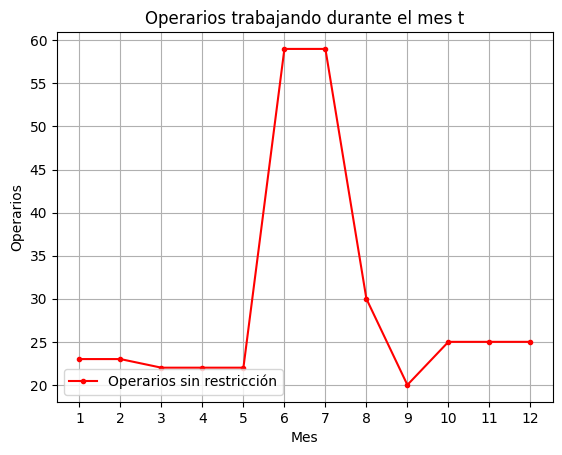

In [ ]:
Work_Force_per_month4 = list(Work_Force4['Value_Decision_Variable'])
plt.plot(PERIODSt, Work_Force_per_month4[1:13], 'r.-',label = 'Operarios sin restricción', c = 'red')

plt.title('Operarios trabajando durante el mes t')
plt.xlabel('Mes')
plt.ylabel('Operarios')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Inventory_per_month4 = list(Inventory_Model4['Value_Decision_Variable'])
Shortages_per_month4 = list(Shortages_Model4['Value_Decision_Variable'])

12 13 12


<ipython-input-100-60cfa409d650>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Inventory_per_month4[1:13], 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
<ipython-input-100-60cfa409d650>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Shortages_per_month4, 'r.-',label = 'Faltantes en el mes', c = 'blue')


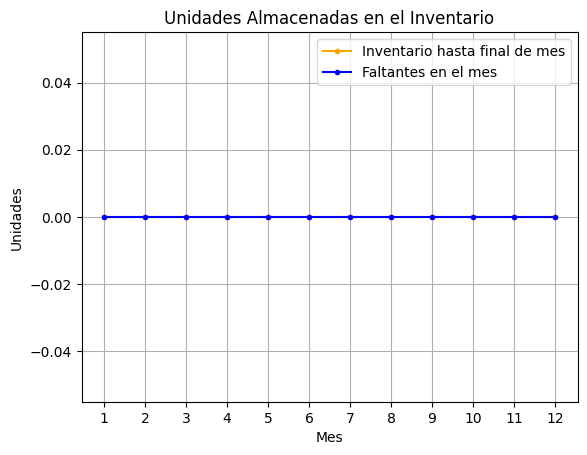

In [ ]:
# Check the lengths of your arrays
print(len(PERIODSt), len(Inventory_per_month4), len(Shortages_per_month4))

# Adjust the length of PERIODSt or the other lists to match
# Example if PERIODSt should have 13 elements:
PERIODSt = list(range(1, 13))  # [1, 2, ..., 13]

plt.plot(PERIODSt, Inventory_per_month4[1:13], 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
plt.plot(PERIODSt, Shortages_per_month4, 'r.-',label = 'Faltantes en el mes', c = 'blue')

plt.title('Unidades Almacenadas en el Inventario')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

## Scenario 5

Shortages in the inventory variable will be taken into account so that the model can determine whether or not it is worth having shortages and therefore no inventories.

In [ ]:
# Setting the scenario
scenario5 = LpProblem("Aggregate_Production_Planning", LpMinimize)

In [ ]:
#Decision Variables
Xt = LpVariable.dicts("Unidades producidas por los operarios y recursos CB en tiempo regular en mes t",t, lowBound = 0, cat = "Integer")
Ht = LpVariable.dicts("Operarios contratados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Lt = LpVariable.dicts("Operarios desvinculados a inicio del mes t",t, lowBound = 0, cat = "Integer")
Wt = LpVariable.dicts("Operarios trabajando durante el mes t",t, lowBound = 0, cat = "Integer")
It = LpVariable.dicts("Unidades en inventario al final del mes t",t, lowBound = 0, cat = "Integer")
St = LpVariable.dicts("Unidades tercerizadas durante el mes t",t, lowBound = 0, cat = "Integer")
Et = LpVariable.dicts("Unidades producidas con horas extras durante el mes t",t, lowBound = 0, cat = "Integer")
Vt = LpVariable.dicts("Unidades vendidas durante el mes t",t, lowBound = 0, cat = "Integer")
Ft = LpVariable.dicts("Unidades faltantes del mes t", t, lowBound = 0, cat = "Integer")

In [ ]:
#Objective Function
scenario5 += lpSum(alpha*Xt[i] for i in t[1:13]) + lpSum((alpha+(epsilon / r))*Et[i] for i in t[1:13]) + lpSum(delta * St[i] for i in t[1:13]) + lpSum(u * It[i] for i in t[1:13]) + lpSum(phi * (Dt[i]-Vt[i]) for i in t[1:13]) + lpSum(theta * Wt[i] for i in t[1:13]) + lpSum(pi * Lt[i] for i in t[1:13]) + lpSum(gamma * Ht[i] for i in t[1:13])

In [ ]:
#Contraints
scenario5 += It[0] == 24152
scenario5 += Wt[0] == 21

for i in t[1:13]:
  scenario5 += (It[i-1] - Ft[i-1] + Xt[i] + Et[i] + St[i] - Vt[i]) == It[i] - Ft[i] # Inventory Balance Equation
for i in t[1:13]:
  scenario5 += c*Dt[i+1] <= It[i] #Policy Constraint
for i in t[1:13]:
  scenario5 += (Wt[i-1] + Ht[i] - Lt[i]) == Wt[i] #Work Balance Equation
for i in t[1:13]:
  scenario5 += Xt[i] <= (r * betha * Nt[i] * ((Wt[i-1] - Lt[i]) + miu * Ht[i]))  #Monthly Production Capacity regular hour MO
for i in t[1:13]:
  scenario5 += p * Xt[i] <= g * k * betha * Mt[i] #Monthly production capacity regular hour MO in bottleneck resource
for i in t[1:13]:
  scenario5 += Et[i] <= (r * TAOt[i] * (Wt[i-1] - Lt[i])) #Production capacity overtime MO
for i in t[1:13]:
  scenario5 += p * Et[i] <= (g * k * LAMBDAt[i]) #Production Capacity Overtime Bottleneck
for i in t[1:13]:
  scenario5 += St[i] <= SIGMAt[i] #Outsourcing capacity
for i in t[1:13]:
  scenario5 += Vt[i] <= Dt[i]  # Sales Limited by Demand
for i in t[1:13]:
  scenario5 += Dt[i] - Vt[i] == Ft[i] #Shortage Equation

In [ ]:
scenario5.solve()
print("Solution Status = ", LpStatus[scenario1.status])

Solution Status =  Optimal


In [ ]:
Name_Variables5 = []
Solution_Variables5 = []
for v in scenario4.variables():
  G = v.name
  H = v.varValue
  print(v.name, "=", v.varValue)
  Name_Variables5.append(G)
  Solution_Variables5.append(H)

Operarios_contratados_a_inicio_del_mes_t_1 = 2.0
Operarios_contratados_a_inicio_del_mes_t_10 = 5.0
Operarios_contratados_a_inicio_del_mes_t_11 = 0.0
Operarios_contratados_a_inicio_del_mes_t_12 = 0.0
Operarios_contratados_a_inicio_del_mes_t_2 = 0.0
Operarios_contratados_a_inicio_del_mes_t_3 = 0.0
Operarios_contratados_a_inicio_del_mes_t_4 = 0.0
Operarios_contratados_a_inicio_del_mes_t_5 = 0.0
Operarios_contratados_a_inicio_del_mes_t_6 = 37.0
Operarios_contratados_a_inicio_del_mes_t_7 = 0.0
Operarios_contratados_a_inicio_del_mes_t_8 = 0.0
Operarios_contratados_a_inicio_del_mes_t_9 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_1 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_10 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_11 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_12 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_2 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_3 = 1.0
Operarios_desvinculados_a_inicio_del_mes_t_4 = 0.0
Operarios_desvinculados_a_inicio_del_mes_t_5 = 0

In [ ]:
# Goal Function
print("Cost Function is $", value(scenario5.objective))

Cost Function is $ 3560.7877298725107


In [ ]:
list_of_tuples5 = list(zip(Name_Variables5, Solution_Variables5))
dff5 = pd.DataFrame(list_of_tuples5, columns = ['Name_Decision_Variable', 'Value_Decision_Variable'])
dff5['letter'] = dff5.Name_Decision_Variable.apply(lambda x: x[:-2])
dff5['number'] = dff5.Name_Decision_Variable.apply(lambda x: int(x[-1:]))
dff5 = dff5.sort_values(by=['letter', 'number'])
dff55 = dff5[['Name_Decision_Variable', 'Value_Decision_Variable']]
dff55

,Name_Decision_Variable,Value_Decision_Variable
0,Operarios_contratados_a_inicio_del_mes_t_1,2.0
4,Operarios_contratados_a_inicio_del_mes_t_2,0.0
5,Operarios_contratados_a_inicio_del_mes_t_3,0.0
6,Operarios_contratados_a_inicio_del_mes_t_4,0.0
7,Operarios_contratados_a_inicio_del_mes_t_5,0.0
8,Operarios_contratados_a_inicio_del_mes_t_6,37.0
9,Operarios_contratados_a_inicio_del_mes_t_7,0.0
10,Operarios_contratados_a_inicio_del_mes_t_8,0.0
11,Operarios_contratados_a_inicio_del_mes_t_9,0.0
1,Operarios_contratados_a_inicio_del_mes_t_10,5.0


In [ ]:
# We are going to analize if we met the demand
Sales_model5 = dff55[dff55['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_vendidas_durante_el_mes_t' in Name_Decision_Variable)]
Sales_model5['Monthly_Demand'] = DEMANDt
Sales_per_month5 = list(Sales_model5['Value_Decision_Variable'])
Sales_model5

<ipython-input-113-698e4f7041b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_model5['Monthly_Demand'] = DEMANDt


,Name_Decision_Variable,Value_Decision_Variable,Monthly_Demand
86,Unidades_vendidas_durante_el_mes_t_1,28430.0,28430
90,Unidades_vendidas_durante_el_mes_t_2,31410.0,31410
91,Unidades_vendidas_durante_el_mes_t_3,30400.0,30400
92,Unidades_vendidas_durante_el_mes_t_4,32570.0,32570
93,Unidades_vendidas_durante_el_mes_t_5,34520.0,34520
94,Unidades_vendidas_durante_el_mes_t_6,32660.0,32660
95,Unidades_vendidas_durante_el_mes_t_7,40800.0,40800
96,Unidades_vendidas_durante_el_mes_t_8,33450.0,33450
97,Unidades_vendidas_durante_el_mes_t_9,27980.0,27980
87,Unidades_vendidas_durante_el_mes_t_10,29550.0,29550


<ipython-input-114-9068a6b2f623>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
<ipython-input-114-9068a6b2f623>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Sales_per_month5, 'r.-', label = 'Ventas', c = 'green')


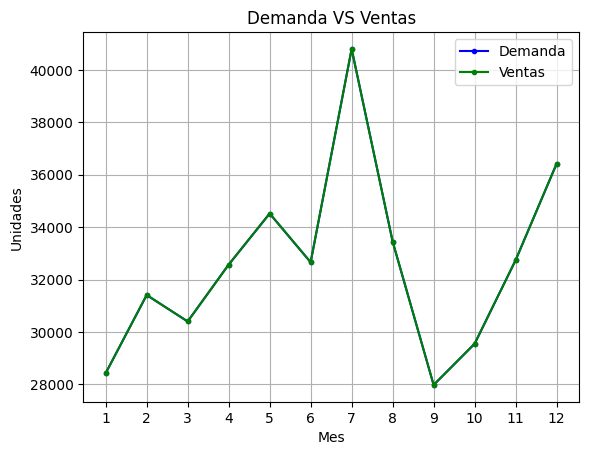

In [ ]:
plt.plot(PERIODSt, DEMANDt, 'r.-',label = 'Demanda', c = 'blue')
plt.plot(PERIODSt, Sales_per_month5, 'r.-', label = 'Ventas', c = 'green')

plt.title('Demanda VS Ventas')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Inventory_Model5 = dff55[dff55['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_en_inventario_al_final_del_mes_t' in Name_Decision_Variable)]
Inventory_Model5

,Name_Decision_Variable,Value_Decision_Variable
37,Unidades_en_inventario_al_final_del_mes_t_0,24152.0
38,Unidades_en_inventario_al_final_del_mes_t_1,0.0
42,Unidades_en_inventario_al_final_del_mes_t_2,0.0
43,Unidades_en_inventario_al_final_del_mes_t_3,0.0
44,Unidades_en_inventario_al_final_del_mes_t_4,0.0
45,Unidades_en_inventario_al_final_del_mes_t_5,0.0
46,Unidades_en_inventario_al_final_del_mes_t_6,0.0
47,Unidades_en_inventario_al_final_del_mes_t_7,0.0
48,Unidades_en_inventario_al_final_del_mes_t_8,0.0
49,Unidades_en_inventario_al_final_del_mes_t_9,0.0


In [ ]:
Work_Force5 = dff55[dff55['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Operarios_trabajando_durante_el_mes_t' in Name_Decision_Variable)]
Work_Force5

,Name_Decision_Variable,Value_Decision_Variable
24,Operarios_trabajando_durante_el_mes_t_0,21.0
25,Operarios_trabajando_durante_el_mes_t_1,23.0
29,Operarios_trabajando_durante_el_mes_t_2,23.0
30,Operarios_trabajando_durante_el_mes_t_3,22.0
31,Operarios_trabajando_durante_el_mes_t_4,22.0
32,Operarios_trabajando_durante_el_mes_t_5,22.0
33,Operarios_trabajando_durante_el_mes_t_6,59.0
34,Operarios_trabajando_durante_el_mes_t_7,59.0
35,Operarios_trabajando_durante_el_mes_t_8,30.0
36,Operarios_trabajando_durante_el_mes_t_9,20.0


In [ ]:
Shortages_Model5 = dff55[dff55['Name_Decision_Variable'].map(lambda Name_Decision_Variable: 'Unidades_faltantes_del_mes_t' in Name_Decision_Variable)]
Shortages_Model5

,Name_Decision_Variable,Value_Decision_Variable
50,Unidades_faltantes_del_mes_t_1,0.0
54,Unidades_faltantes_del_mes_t_2,0.0
55,Unidades_faltantes_del_mes_t_3,0.0
56,Unidades_faltantes_del_mes_t_4,0.0
57,Unidades_faltantes_del_mes_t_5,0.0
58,Unidades_faltantes_del_mes_t_6,0.0
59,Unidades_faltantes_del_mes_t_7,0.0
60,Unidades_faltantes_del_mes_t_8,0.0
61,Unidades_faltantes_del_mes_t_9,0.0
51,Unidades_faltantes_del_mes_t_10,0.0


<ipython-input-118-9e078c77a195>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Work_Force_per_month5[1:13], 'r.-',label = 'Operarios sin restricción', c = 'red')


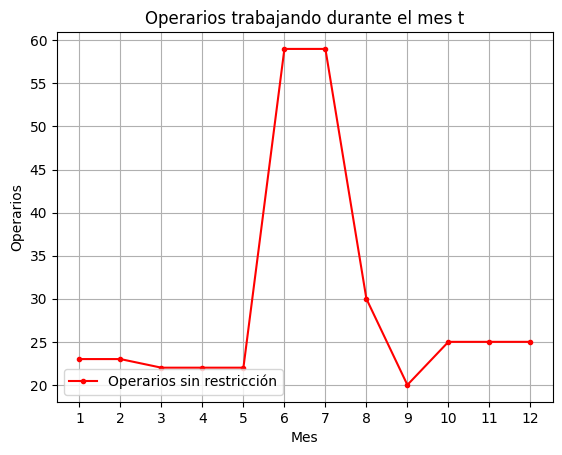

In [ ]:
Work_Force_per_month5 = list(Work_Force4['Value_Decision_Variable'])
plt.plot(PERIODSt, Work_Force_per_month5[1:13], 'r.-',label = 'Operarios sin restricción', c = 'red')

plt.title('Operarios trabajando durante el mes t')
plt.xlabel('Mes')
plt.ylabel('Operarios')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()

In [ ]:
Inventory_per_month5 = list(Inventory_Model5['Value_Decision_Variable'])
Shortages_per_month5 = list(Shortages_Model5['Value_Decision_Variable'])

12 13 12


<ipython-input-120-1f662c633578>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Inventory_per_month5[1:13], 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
<ipython-input-120-1f662c633578>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r.-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PERIODSt, Shortages_per_month5, 'r.-',label = 'Faltantes en el mes', c = 'blue')


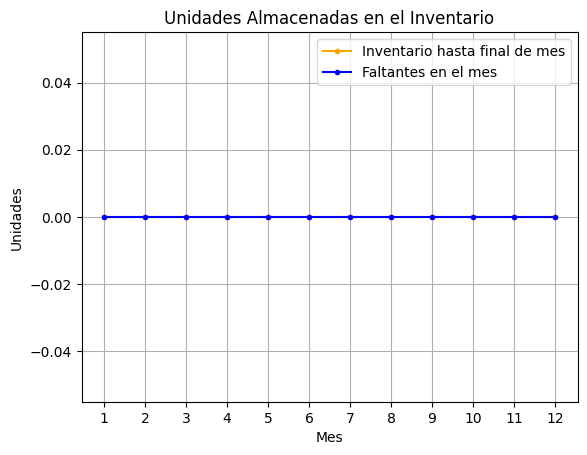

In [ ]:
# Check the lengths of your arrays
print(len(PERIODSt), len(Inventory_per_month5), len(Shortages_per_month5))

# Adjust the length of PERIODSt or the other lists to match
# Example if PERIODSt should have 13 elements:
PERIODSt = list(range(1, 13))  # [1, 2, ..., 13]

plt.plot(PERIODSt, Inventory_per_month5[1:13], 'r.-',label = 'Inventario hasta final de mes', c = 'orange')
plt.plot(PERIODSt, Shortages_per_month5, 'r.-',label = 'Faltantes en el mes', c = 'blue')

plt.title('Unidades Almacenadas en el Inventario')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.legend()